In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] ='4'
os.environ['PYOPENGL_PLATFORM'] = 'osmesa'
import torch
import logging
import time
from argparse import ArgumentParser

import cv2
import json_tricks as json
import numpy as np


from pose_pipeline.utils.jupyter import play,play_grid
from pose_pipeline.pipeline import BlurredVideo,LiftingPerson,LiftingMethod,TopDownPerson,Video
from multi_camera.datajoint.multi_camera_dj import PersonKeypointReconstruction,SingleCameraVideo, CalibratedRecording, MultiCameraRecording,PersonKeypointReconstructionMethod
from multi_camera.datajoint.sessions import Recording
from hand_dj import HandBbox,HandBboxMethod, HandPoseEstimation,HandPoseEstimationMethod,HandPoseEstimationVideo

[2023-12-20 13:35:34,164][INFO]: Connecting pfirouzabadi@127.0.0.1:3306
[2023-12-20 13:35:34,199][INFO]: Connected pfirouzabadi@127.0.0.1:3306


In [7]:
participant_idx = 1
participant_videos = (Recording & 'participant_id="m002"').fetch('KEY')[participant_idx]
vid_keys= (SingleCameraVideo & participant_videos).fetch('KEY')
len(vid_keys)

48

In [ ]:
# vid_keys = (HandBbox & 'filename LIKE "m001%"').fetch('KEY')
for k in vid_keys:
    k['detection_method'] = 0 
vid_keys 

In [12]:
# HandBboxMethod.insert(vid_keys)
# HandBbox.populate()
HandBbox()

recording_timestamps,camera_config_hash,video_project,filename,detection_method,num_boxes,bboxes
2023-09-26 11:07:17,0cbbed837e,HAND_TEST,m001_20230926_110717.23106516,0,2,=BLOB=
2023-09-26 11:07:17,0cbbed837e,HAND_TEST,m001_20230926_110717.23106523,0,2,=BLOB=
2023-09-26 11:07:17,0cbbed837e,HAND_TEST,m001_20230926_110717.23106526,0,2,=BLOB=
2023-09-26 11:07:17,0cbbed837e,HAND_TEST,m001_20230926_110717.23106528,0,2,=BLOB=
2023-09-26 11:07:17,0cbbed837e,HAND_TEST,m001_20230926_110717.23106529,0,2,=BLOB=
2023-09-26 11:07:17,0cbbed837e,HAND_TEST,m001_20230926_110717.23106530,0,2,=BLOB=
2023-09-26 11:07:17,0cbbed837e,HAND_TEST,m001_20230926_110717.23106532,0,2,=BLOB=
2023-09-26 11:07:17,0cbbed837e,HAND_TEST,m001_20230926_110717.23106539,0,2,=BLOB=
2023-09-26 11:08:13,0cbbed837e,HAND_TEST,m001_20230926_110813.23106516,0,3,=BLOB=
2023-09-26 11:08:13,0cbbed837e,HAND_TEST,m001_20230926_110813.23106523,0,3,=BLOB=


In [14]:
# HandPoseEstimationMethod.insert(vid_keys)
# HandPoseEstimation.populate()
HandPoseEstimation()

# Visualization

In [27]:
def render_video(video, output_file, keypoints):
    cap = cv2.VideoCapture(video)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    fps = cap.get(cv2.CAP_PROP_FPS)
    output_size = (int(w),int(h))

    fourcc = cv2.VideoWriter_fourcc(*"MP4V")
    out = cv2.VideoWriter(output_file,fourcc, fps,output_size)

    for frame_idx in tqdm(range(total_frames)):
        success, frame = cap.read()

        if not success:
            break
        keypoints = keypoints[frame_idx,:,:].copy()
        frame = draw_keypoints(frame,keypoints)
        out.write(frame)

    out.release()
    cap.release()

In [31]:
participant_idx = 1
participant_videos = (Recording & 'participant_id="m002"').fetch('KEY')[participant_idx]
vid_keys= (HandPoseEstimation * SingleCameraVideo & participant_videos).fetch('KEY')
num_cameras = len(vid_keys)
num_cameras

12

In [34]:
(HandPoseEstimationVideo & vid_keys[5]).fetch("output_video")

array(['tmpex_ic_co.mp4'], dtype=object)

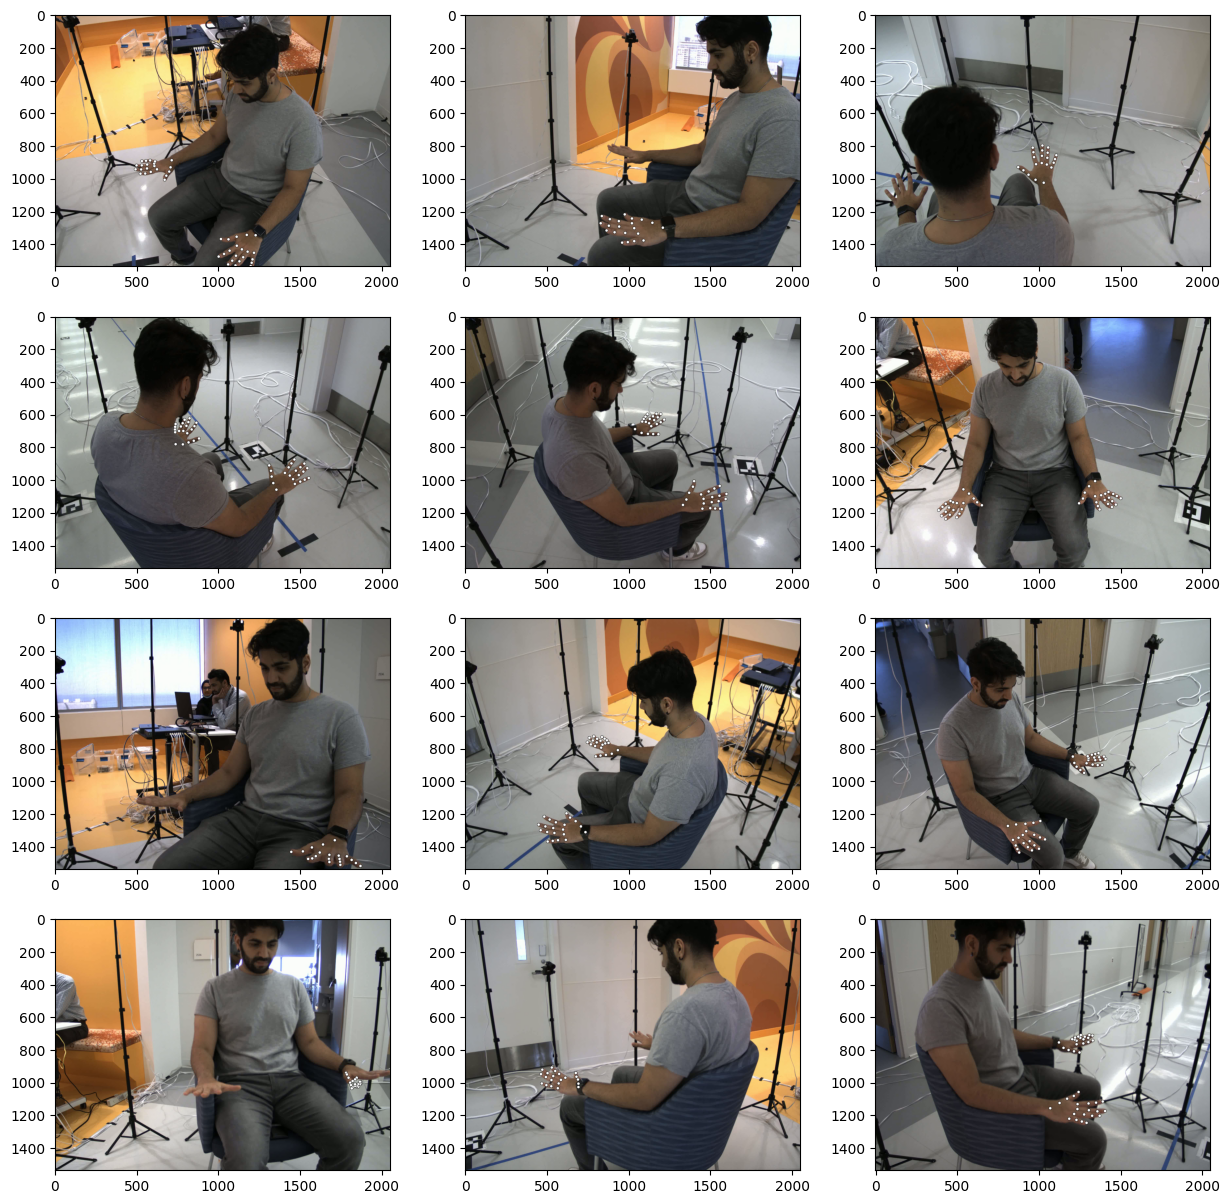

In [32]:
%matplotlib inline
# using the variable axs for multiple Axes
from pose_pipeline.utils.visualization import draw_keypoints
n_cols = 3
fig, axs = plt.subplots(num_cameras//n_cols,n_cols,figsize=(15,15))

for vid_idx in range(num_cameras):
    vid_file = (Video &vid_keys[vid_idx]).fetch('video')[0]
    # output_file = f'{output_root}m002_camera{vid_idx}.mp4'
    
    cap = cv2.VideoCapture(vid_file)
    frame_idx = 0
    video_writer = None
    pred_instances_list = []
    keypoints_2d = (HandPoseEstimation & vid_keys[vid_idx]).fetch1("keypoints_2d")
    ###############################CHOOSE A FRAME#########################
    # while frame_idx < 1:
    success, frame = cap.read()
    frame_idx += 1

    if not success:
        break
    radius = 10
    threshold = 0.2
    color = (255,255,255)
    border_color = (0,0,0)
    for k in keypoints_2d[frame_idx]:
        keypoints = k[:,:].copy()
        frame = draw_keypoints(frame,keypoints)

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    row = vid_idx // n_cols
    col = vid_idx % n_cols
    axs[row,col].imshow(frame)
    os.remove(vid_file)